# Bayesian model-based optimizations

[Source](https://sigopt.com/static/pdf/SigOpt_Bayesian_Optimization_Primer.pdf)

There are four parts to an optimization problem:

1. **Objective function**: what we want to minimize
2. **Domain space**: values of the parameters over which to minimize the objective
3. **Hyperparameter optimization function**: constructs the surrogate function and chooses next values to evaluate
4. **Trials**: score, parameter pairs recorded each time we evaluate the objective function

Rather than just selecting from a grid uninformed by past objective function evaluations, Bayesian methods take into account the previous results to try more promising values. 

They work by constructing a probability model of the objective function (called a surrogate function) $p(\text{score} | \text{parameters})$ which is much easier to optimize than the actual objective function.

After each evaluation of the objective function, the algorithm updates the probability model (usually given as $p(y | x)$ incorporating the new results. Sequential Model-Based Optimization (SMBO) methods are a formalization of Bayesian optimization that update the probability model sequentially: every evaluation of the objective function with a set of values updates the model with the idea that eventually the model will come to represent the true objective function. This is an application of Bayesian Reasoning. The algorithm forms an initial idea of the objective function and updates it with each new piece of evidence.

The next values to try in the objective function are selected by the algorithm optmizing the probability model (surrogate function) usually with a criteria known as Expected Improvement. Finding the values that will yield the greatest expected improvement in the surrogate function is much cheaper than evaluating the objective function itself. By choosing the next values based on a model rather than randomly, the hope is that the algorithm with converge to the true best values much quicker. The overall goal is to evaluate the objective function fewer times by spending a little more time choosing the next values. Overall, Bayesian Optimization and SMBO methods:

* Converge to a lower score of the objective function than random search
* Require far less time to find the optimum of the objective function

SMBO methods differ in part 3, the algorithm used to construct the probability model (also called the Surrogate Function). Several options are for the surrogate function are:

* Gaussian Processes
* Tree-structured Parzen Estimator
* Random Forest Regression

Here we use Hyperopt implementation the Tree-strucuted Parzen Estimator.

In [1]:
%matplotlib inline 

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

/Users/adhiman/anaconda3/envs/python3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## Objective

A polynomial function with the goal being to find the minimum value. 

In [2]:
def objective(x):
    """Objective function to minimize"""
    
    # Create the polynomial object
    f = np.poly1d([1, -2, -28, 28, 12, -26, 100])

    # Return the value of the polynomial
    return f(x) * 0.05

Minimum of -219.8012 occurs at 4.8779


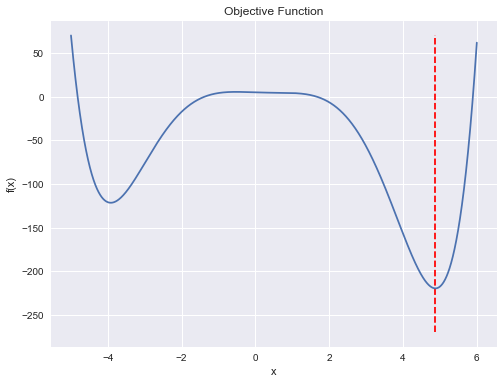

In [3]:
# Space over which to evluate the function is -5 to 6
x = np.linspace(-5, 6, 10000)
y = objective(x)

miny = min(y)
minx = x[np.argmin(y)]

# Visualize the function
plt.figure(figsize = (8, 6))
plt.title('Objective Function'); plt.xlabel('x'); plt.ylabel('f(x)')
plt.vlines(minx, min(y)- 50, max(y), linestyles = '--', colors = 'r')
plt.plot(x, y);

# Print out the minimum of the function and value
print('Minimum of %0.4f occurs at %0.4f' % (miny, minx))

## Domain

The domain is the values of x over which we evaluate the function. First we can use a uniform distribution over the space our function is defined.

In [4]:
from hyperopt import hp

# Create the domain space
space = hp.uniform('x', -5, 6)

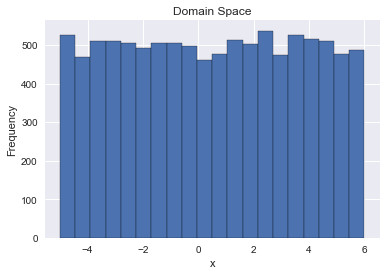

In [5]:
from hyperopt.pyll.stochastic import sample


samples = []

# Sample 10000 values from the range
for _ in range(10000):
    samples.append(sample(space))
    

# Histogram of the values
plt.hist(samples, bins = 20, edgecolor = 'black'); 
plt.xlabel('x'); plt.ylabel('Frequency'); plt.title('Domain Space');

## Hyperparameter Optimization Algorithm

There are two choices for a hyperparameter optimization algorithm in Hyperopt: random and Tree Parzen Estimator. 

In [6]:
from hyperopt import rand, tpe

# Create the algorithms
tpe_algo = tpe.suggest
rand_algo = rand.suggest

In [7]:
from hyperopt import Trials

# Create two trials objects
tpe_trials = Trials()
rand_trials = Trials()

In [8]:
from hyperopt import fmin

# Run 2000 evals with the tpe algorithm
tpe_best = fmin(fn=objective, space=space, algo=tpe_algo, trials=tpe_trials, 
                max_evals=2000, rstate= np.random.RandomState(50))

print(tpe_best)

# Run 2000 evals with the random algorithm
rand_best = fmin(fn=objective, space=space, algo=rand_algo, trials=rand_trials, 
                 max_evals=2000, rstate= np.random.RandomState(50))

print(rand_best)

{'x': 4.878481851906148}
{'x': 4.877613189834774}


In [9]:
# Print out information about losses
print('Minimum loss attained with TPE:    {:.4f}'.format(tpe_trials.best_trial['result']['loss']))
print('Minimum loss attained with random: {:.4f}'.format(rand_trials.best_trial['result']['loss']))
print('Actual minimum of f(x):            {:.4f}'.format(miny))

# Print out information about number of trials
print('\nNumber of trials needed to attain minimum with TPE:    {}'.format(tpe_trials.best_trial['misc']['idxs']['x'][0]))
print('Number of trials needed to attain minimum with random: {}'.format(rand_trials.best_trial['misc']['idxs']['x'][0]))

# Print out information about value of x
print('\nBest value of x from TPE:    {:.4f}'.format(tpe_best['x']))
print('Best value of x from random: {:.4f}'.format(rand_best['x']))
print('Actual best value of x:      {:.4f}'.format(minx))

Minimum loss attained with TPE:    -219.8012
Minimum loss attained with random: -219.8012
Actual minimum of f(x):            -219.8012

Number of trials needed to attain minimum with TPE:    655
Number of trials needed to attain minimum with random: 235

Best value of x from TPE:    4.8785
Best value of x from random: 4.8776
Actual best value of x:      4.8779


In [10]:
%%timeit -n 3
# Run 2000 evals with the tpe algorithm
best = fmin(fn=objective, space=space, algo=tpe_algo, max_evals=200)

524 ms ± 24.8 ms per loop (mean ± std. dev. of 7 runs, 3 loops each)


In [11]:
%%timeit -n 3

# Run 2000 evals with the random algorithm
best = fmin(fn=objective, space=space, algo=rand_algo, max_evals=200)

127 ms ± 13.7 ms per loop (mean ± std. dev. of 7 runs, 3 loops each)


## Results

In [12]:
tpe_results = pd.DataFrame({'loss': [x['loss'] for x in tpe_trials.results], 'iteration': tpe_trials.idxs_vals[0]['x'],
                            'x': tpe_trials.idxs_vals[1]['x']})
                            
tpe_results.head()

,iteration,loss,x
0,0,36.210073,5.957885
1,1,-202.384052,4.470885
2,2,-75.519449,3.218963
3,3,5.543552,-0.515859
4,4,35.078011,-4.916832


In [13]:
tpe_results['rolling_average_x'] = tpe_results['x'].rolling(50).mean().fillna(method = 'bfill')
tpe_results['rolling_average_loss'] = tpe_results['loss'].rolling(50).mean().fillna(method = 'bfill')
tpe_results.head()

,iteration,loss,x,rolling_average_x,rolling_average_loss
0,0,36.210073,5.957885,2.105103,-74.393795
1,1,-202.384052,4.470885,2.105103,-74.393795
2,2,-75.519449,3.218963,2.105103,-74.393795
3,3,5.543552,-0.515859,2.105103,-74.393795
4,4,35.078011,-4.916832,2.105103,-74.393795


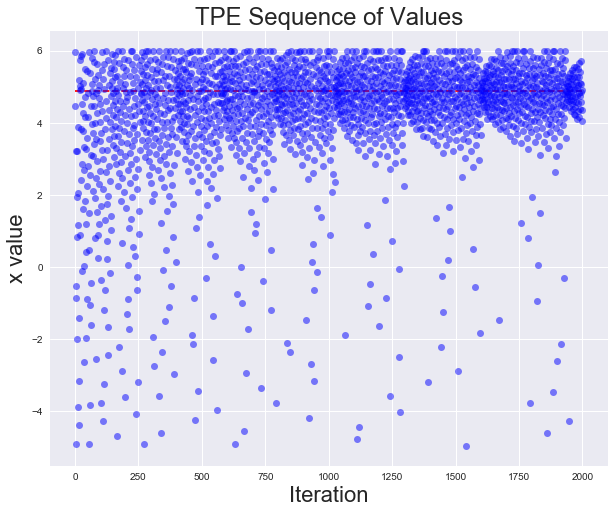

In [14]:
plt.figure(figsize = (10, 8))
plt.plot(tpe_results['iteration'], tpe_results['x'],  'bo', alpha = 0.5);
plt.xlabel('Iteration', size = 22); plt.ylabel('x value', size = 22); plt.title('TPE Sequence of Values', size = 24);
plt.hlines(minx, 0, 2000, linestyles = '--', colors = 'r');

As the algorithm progresses, these should tend to cluster around the actual best value (near 4.9)

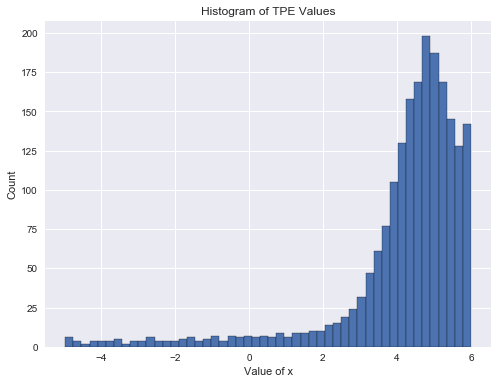

In [15]:
plt.figure(figsize = (8, 6))
plt.hist(tpe_results['x'], bins = 50, edgecolor = 'k');
plt.title('Histogram of TPE Values'); plt.xlabel('Value of x'); plt.ylabel('Count');

Best Loss of -219.8012 occured at iteration 655


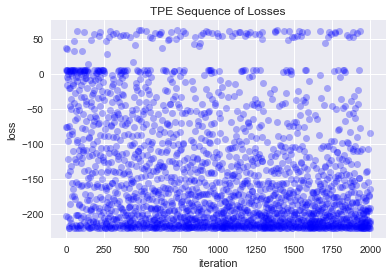

In [16]:
# Sort with best loss first
tpe_results = tpe_results.sort_values('loss', ascending = True).reset_index()

plt.plot(tpe_results['iteration'], tpe_results['loss'], 'bo', alpha = 0.3);
plt.xlabel('iteration'); plt.ylabel('loss'); plt.title('TPE Sequence of Losses');

print('Best Loss of {:.4f} occured at iteration {}'.format(tpe_results['loss'][0], tpe_results['iteration'][0]))

In [17]:
rand_results = pd.DataFrame({'loss': [x['loss'] for x in rand_trials.results], 'iteration': rand_trials.idxs_vals[0]['x'],
                            'x': rand_trials.idxs_vals[1]['x']})
                            
rand_results.head()

,iteration,loss,x
0,0,36.210073,5.957885
1,1,-202.384052,4.470885
2,2,-75.519449,3.218963
3,3,5.543552,-0.515859
4,4,35.078011,-4.916832


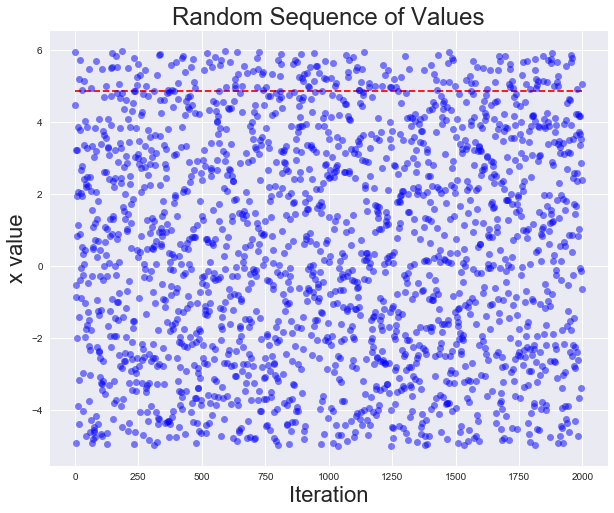

In [18]:
plt.figure(figsize = (10, 8))
plt.plot(rand_results['iteration'], rand_results['x'],  'bo', alpha = 0.5);
plt.xlabel('Iteration', size = 22); plt.ylabel('x value', size = 22); plt.title('Random Sequence of Values', size = 24);
plt.hlines(minx, 0, 2000, linestyles = '--', colors = 'r');

We should contrast the TPE results with those from random search. Here we do not expect to see any trend in values evaluated over time because the values are selected randomly.

Best Loss of -219.8012 occured at iteration 235


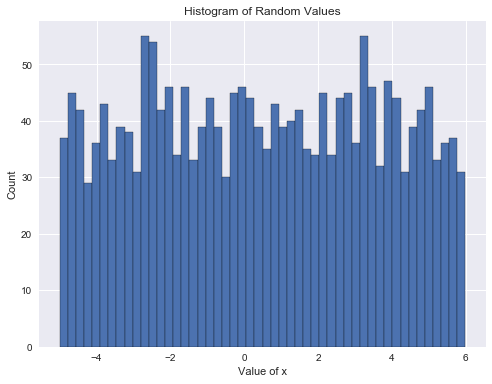

In [19]:
# Sort with best loss first
rand_results = rand_results.sort_values('loss', ascending = True).reset_index()

plt.figure(figsize = (8, 6))
plt.hist(rand_results['x'], bins = 50, edgecolor = 'k');
plt.title('Histogram of Random Values'); plt.xlabel('Value of x'); plt.ylabel('Count');

# Print information
print('Best Loss of {:.4f} occured at iteration {}'.format(rand_results['loss'][0], rand_results['iteration'][0]))

# Better domain space

Here we will make a normally distributed domain space around the value where the minimum of the objective function occurs, around 4.9.

In [20]:
# Normally distributed space
space = hp.normal('x', 4.9, 0.5)

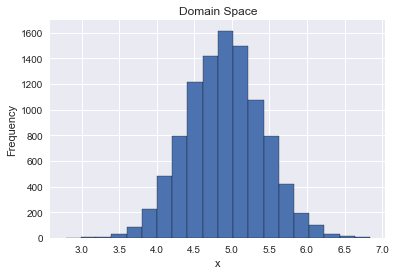

In [21]:
samples = []

# Sample 10000 values from the range
for _ in range(10000):
    samples.append(sample(space))
    

# Histogram of the values
plt.hist(samples, bins = 20, edgecolor = 'black'); 
plt.xlabel('x'); plt.ylabel('Frequency'); plt.title('Domain Space');

In [22]:
from hyperopt import STATUS_OK
from timeit import default_timer as timer

In [23]:
def objective(x):
    """Objective function to minimize with smarter return values"""
    
    # Create the polynomial object
    f = np.poly1d([1, -2, -28, 28, 12, -26, 100])

    # Evaluate the function
    start = timer()
    loss = f(x) * 0.05
    end = timer()
    
    # Calculate time to evaluate
    time_elapsed = end - start
    
    results = {'loss': loss, 'status': STATUS_OK, 'x': x, 'time': time_elapsed}
    
    # Return dictionary
    return results

In [24]:
# New trials object
trials = Trials()

# Run 2000 evals with the tpe algorithm
best = fmin(fn=objective, space=space, algo=tpe_algo, trials=trials, 
                max_evals=2000, rstate= np.random.RandomState(120))

In [25]:
results = trials.results
results[:2]

[{'loss': -189.3682041842684,
  'status': 'ok',
  'x': 5.312379584994148,
  'time': 5.372700979933143e-05},
 {'loss': -219.325099632915,
  'status': 'ok',
  'x': 4.8166084516702705,
  'time': 5.085500015411526e-05}]

In [26]:
# Results into a dataframe
results_df = pd.DataFrame({'time': [x['time'] for x in results], 
                           'loss': [x['loss'] for x in results],
                           'x': [x['x'] for x in results],
                            'iteration': list(range(len(results)))})

# Sort with lowest loss on top
results_df = results_df.sort_values('loss', ascending = True)
results_df.head()

,iteration,loss,time,x
956,956,-219.801204,0.000031,4.878152
1316,1316,-219.801204,0.000032,4.878111
402,402,-219.801204,0.000030,4.878189
914,914,-219.801203,0.000032,4.878064
1954,1954,-219.801203,0.000034,4.878222


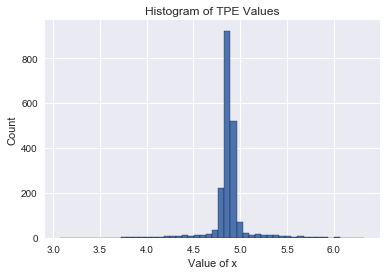

In [27]:
plt.hist(results_df['x'], bins = 50, edgecolor = 'k');
plt.title('Histogram of TPE Values'); plt.xlabel('Value of x'); plt.ylabel('Count');

/Users/adhiman/anaconda3/envs/python3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


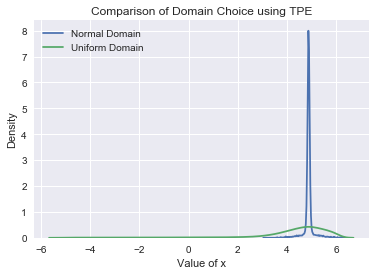

In [28]:
sns.kdeplot(results_df['x'], label = 'Normal Domain')
sns.kdeplot(tpe_results['x'], label = 'Uniform Domain')
plt.legend(); plt.xlabel('Value of x'); plt.ylabel('Density'); plt.title('Comparison of Domain Choice using TPE');

In [29]:
print('Lowest Value of the Objective Function = {:.4f} at x = {:.4f} found in {:.0f} iterations.'.format(results_df['loss'].min(),
                                                                             results_df.loc[results_df['loss'].idxmin()]['x'],
                                                                             results_df.loc[results_df['loss'].idxmin()]['iteration']))

Lowest Value of the Objective Function = -219.8012 at x = 4.8782 found in 956 iterations.


# One-line optimization

In [30]:
best = fmin(fn = lambda x: np.poly1d([1, -2, -28, 28, 12, -26, 100])(x) * 0.05,
            space = hp.normal('x', 4.9, 0.5), algo=tpe.suggest, 
            max_evals = 2000)

best

{'x': 4.878118154151056}